Importing Packages

In [36]:
import torch
from torch.optim import Adam
from torch.optim import LBFGS
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np
import copy

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML
import seaborn as sns
sns.set_style('darkgrid')

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import widgets
from IPython.display import display

import plotly.express as px
import dash
from dash import Dash, dcc, html, Input, Output, State

Helper function to create a grid

In [37]:
def grid(x,y,nx,ny):
    grid_arr = list()
    sx, sy = 0,0
    if (nx == 1): sx = x
    if (ny == 1): sy = y
    xs = torch.linspace(sx,x,nx)
    ys = torch.linspace(sy,y,ny)
    for x in xs:
        for y in ys:
            grid_arr.append((x.item(),y.item()))
    grid_arr = torch.tensor(grid_arr)
    return grid_arr

Physical System to Model: 2D Deformation, Linear Isotropic

Training tensor within region of interest

In [38]:
# Range of x and y to be modelled
x_range, x_int = 10, 100
y_range, y_int = 10e-3, 5
train = grid(x_range,y_range,x_int,y_int).requires_grad_(True).to(device)

#DBC, positions and displacments
# Fixing y in place at x = 0
pos = grid(0,y_range,1,y_int)
disp = grid(0,0,1,y_int)
pos, disp = pos.requires_grad_(True).to(device),disp.requires_grad_(True).to(device)
DBC = [pos,disp]

#NBC, Scalar Traction Force, Normal Vector, and Position.
T_hat = [(9500.0/(10e-3)**2,0)]
n_hat = [(1.0,0)]
T_pos = grid(5,y_range,1,y_int).requires_grad_(True).to(device)
T_hat, n_hat = torch.tensor(T_hat).requires_grad_(True).t().to(device),torch.tensor(n_hat).requires_grad_(True).t().to(device)
NBC = [T_hat,n_hat,T_pos]


# Physical Parameters, E = Youngs Modulus (Pa), v = Poisson's ratio (Typically [-1,0.5]).
# Steel
p = dict(E=210e9, v=0.26)
#Stiffness mat, 2D
C = [[1, -p['v'], 0],
     [-p['v'], 1, 0],
     [0, 0, 1+p['v']]]
C = torch.tensor(C).to(device)
C = C/p['E']
C = C.requires_grad_(True)

Solution:

With Force (F), Area (A), Length (L), and Elastic Modulus (E), $\delta = \frac{\sigma L}{E} = \frac{\frac{F}{A} L}{E}$

$F = 9500N, A = 100mm^2, L = 10m, E = 210 GPa, \delta = 4.52mm$

In [39]:
#sol

Plotting

In [40]:
def plot_comp():
    plot_input = train.clone()
    pred = model(plot_input)
    
    _, loss_absolute = loss_fn(model, plot_input)
    pred_plot = pred.cpu().detach().numpy() + plot_input.cpu().detach().numpy()

    plt.scatter(pred_plot[:,0].T,pred_plot[:,1].T,label='Deformed',marker='.')
    plt.xlabel('Position')
    plt.title(f"Deformation, Loss: {loss_absolute:.2E}, Epoch {epoch}")
    plt.show()
    plt.clf()

Creating the Model

In [41]:
# i_num nodes, i_len nodes per layer and Tanh activation fn, wide and shallow (64x4)
i_num = 2
i_len = 64
#params to take and approximate
params_in = 2
params_out = 2

# fn to create model
def pinn(input_size, output_size, num_layers, nodes_per_layer, activation):
    layers = []
    
    # Input layer
    layers.append(nn.Linear(input_size, nodes_per_layer))
    
    # Hidden layers
    for layer in range(num_layers):
        layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
        if layer == 0 and activation==Siren:
            layers.append(activation(l=0))
        else:
            layers.append(activation())
    
    # Output layer
    layers.append(nn.Linear(nodes_per_layer, output_size))
    
    return nn.Sequential(*layers)

# custom trainable Tanh activation fn
class TTanh(nn.Module):
    def __init__(self, features=i_len):
        super().__init__()
        self.features = features
        self.a = nn.Parameter(torch.randn(1, features))
        
    def forward(self, x):
        return torch.tanh(self.a * x)

#custom SIREN activation fn
class Siren(nn.Module):
    def __init__(self, features=i_len, l=1):
        super(Siren, self).__init__()
        self.features = features
        # Learnable parameters for the phase and bias
        if l: w = 1 
        else: w = 30
        n = torch.sqrt(torch.tensor(6.0/features))
        self.a_weight = nn.Parameter((torch.rand(1, features) *2*n - n)*w)
        self.a_bias = nn.Parameter(torch.randn(1, features))

    def forward(self, x):
        # Apply the periodic activation function
        return torch.sin( self.a_weight*x + self.a_bias)

# Model to be trained using only Adam
model = pinn(params_in, params_out, i_num, i_len, TTanh)
model.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=64, bias=True)
  (2): TTanh()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): TTanh()
  (5): Linear(in_features=64, out_features=2, bias=True)
)

Loss Function has the following components:

Physics Loss:

$\mathcal{L}_{Phy} = \frac{1}{N}\sum[\frac{\partial \sigma_{ij}}{\partial x_{j}}]^2$

NBC Loss:

$\mathcal{L}_{NBC} = \frac{1}{N}\sum[\sigma.n - \hat{T}]^2$

DBC Loss:

$\mathcal{L}_{DBC} = \frac{1}{N}\sum[u-\hat{u}]^2$

In [42]:
def Stress(model,input):
    # Strain from displacement field
    pred = model(input)
    
    dux = torch.autograd.grad(pred[:,0], input, torch.ones_like(pred[:,0]), retain_graph=True, create_graph=True)[0]
    duy = torch.autograd.grad(pred[:,1], input, torch.ones_like(pred[:,1]), retain_graph=True, create_graph=True)[0]
    
    duxdx = dux[:,0]
    duxdy = dux[:,1]
    duydx = duy[:,0]
    duydy = duy[:,1]

    epsilon = torch.stack((duxdx, duydy, 0.5 * (duydx + duxdy)))
    
    # Stress from Strain and Constitutive matrix
    sigma_3xn = C @ epsilon

    return sigma_3xn[0,:],sigma_3xn[1,:],sigma_3xn[2,:]

In [43]:
def loss_fn(model, batch):
    # model: model
    # batch: vector with x

    # Calulate loss from initial conditions (DBC)
    DBC_loss = ((model(DBC[0])-DBC[1])**2).mean()

    #Calculating NBC Loss
    sxx_NBC,syy_NBC,sxy_NBC = Stress(model,NBC[2])
    syx_NBC = sxy_NBC.clone()

    sigma_1x2_x_NBC = torch.stack((sxx_NBC,syx_NBC), dim=1)
    sigma_1x2_y_NBC = torch.stack((sxy_NBC,syy_NBC), dim=1)
    sigma_2x2_NBC = torch.stack((sigma_1x2_x_NBC, sigma_1x2_y_NBC), dim=1)

    #NBC Loss
    NBC_loss = (((sigma_2x2_NBC @ NBC[1]) - NBC[0])**2).mean()


    #Physics Loss
    #Stress
    sxx_phy,syy_phy,sxy_phy = Stress(model,batch)

    #Divergence of Stress
    dsxx = torch.autograd.grad(sxx_phy, batch, torch.ones_like(sxx_phy), retain_graph=True, create_graph=True)[0]
    dsyy = torch.autograd.grad(syy_phy, batch, torch.ones_like(sxx_phy), retain_graph=True, create_graph=True)[0]
    dsxy = torch.autograd.grad(sxy_phy, batch, torch.ones_like(sxx_phy), retain_graph=True, create_graph=True)[0]

    dsxxdx = dsxx[:,0]
    dsyydy = dsyy[:,1]
    dsxydx = dsxy[:,0]
    dsxydy = dsxy[:,1]

    div_stress = torch.stack((dsxxdx + dsxydy, dsyydy + dsxydx), dim=0)
    phy_loss = ((div_stress)**2).mean()


    # calculate weighted loss
    DBC_loss_weighted,NBC_loss_weighted = DBC_loss*DBC_weight , NBC_loss*NBC_weight

    obtain_grads([DBC_loss_weighted, NBC_loss_weighted, phy_loss])

    loss_weighted = DBC_loss_weighted + NBC_loss_weighted + phy_loss
    loss_absolute = DBC_loss + NBC_loss + phy_loss

    return loss_weighted, loss_absolute

Loss weights are dynamically updated using:

$\hat{\lambda}^{(n)}_{ic} = \frac{max \{| {\nabla_{\theta}} \mathcal{L}_{physics} |\} } {| \overline{ {\nabla_{\theta}} \mathcal{L}_{ic} } |} $
or
$ \frac{std \{ {\nabla_{\theta}} \mathcal{L}_{physics} \} } {std \{ {\nabla_{\theta}} \mathcal{L}_{ic} \} } $
or
$\frac{|| {\nabla_{\theta}} \mathcal{L}_{physics} ||_{2} } {|| {\nabla_{\theta}} \mathcal{L}_{ic} ||_{2} } $

$\lambda^{(n)}_{ic} = \alpha \lambda^{(n-1)}_{ic} + (1 - \alpha) \hat{\lambda}^{(n)}_{ic}  $

In [44]:
phy_grads, NBC_grads, DBC_grads = list(), list(), list()
list_of_lists = [DBC_grads, NBC_grads, phy_grads]
NBC_weight, DBC_weight = 1.0, 1.0

def weight_update_max_mean(w_update, a=0.9):
    phy_loss_max = torch.max(torch.abs(torch.stack(phy_grads[-w_update:])))
    
    NBC_loss_mean = torch.mean(torch.abs(torch.stack(NBC_grads[-w_update:])))
    NBC_weight_hat = (phy_loss_max / NBC_loss_mean).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_mean = torch.mean(torch.abs(torch.stack(DBC_grads[-w_update:])))
    DBC_weight_hat = (phy_loss_max / DBC_loss_mean).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def weight_update_std(w_update, a=0.9):
    phy_loss_std = torch.std(torch.stack(phy_grads[-w_update:]))

    NBC_loss_std = torch.std(torch.stack(NBC_grads[-w_update:]))
    NBC_weight_hat = (phy_loss_std / NBC_loss_std).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_std = torch.std(torch.stack(DBC_grads[-w_update:]))
    DBC_weight_hat = (phy_loss_std / DBC_loss_std).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def weight_update_norm(w_update, a=0.9):
    phy_loss_norm = torch.linalg.matrix_norm(torch.stack(phy_grads[-w_update:]))
    
    NBC_loss_norm = torch.linalg.matrix_norm(torch.stack(NBC_grads[-w_update:]))
    NBC_weight_hat = (phy_loss_norm / NBC_loss_norm).item()
    new_NBC_weight = (1-a)*NBC_weight + a*NBC_weight_hat

    DBC_loss_norm = torch.linalg.matrix_norm(torch.stack(DBC_grads[-w_update:]))
    DBC_weight_hat = (phy_loss_norm / DBC_loss_norm).item()
    new_DBC_weight = (1-a)*DBC_weight + a*DBC_weight_hat

    return new_NBC_weight, new_DBC_weight

def obtain_grads(losses):

    for i in range(len(list_of_lists)):
        optim.zero_grad()
        losses[i].backward(retain_graph=True)
        temp = list()
        for name, param in model.named_parameters():
            if param.grad is not None:
                temp.append(torch.reshape(param.grad,(-1,)))
        list_of_lists[i].append(torch.cat(temp))
        
    return

Checkpoint During Training

In [45]:
best_model_adam = {'epoch':-1}
best_model_LBFGS = {'epoch':-1}
best_model = {'epoch':-1}

def checkpoint(best_model):
    if (best_model['epoch'] == -1) or (prev_loss[-1] < best_model['loss']):
        best_model = {
            'epoch': epoch,
            'model_state_dict': copy.deepcopy(copy.deepcopy(model.state_dict())),
            'optimizer_state_dict': copy.deepcopy(copy.deepcopy(optim.state_dict())),
            'loss': prev_loss[-1],
            'model_params':[params_in, params_out, i_num, i_len]
                    }
    return best_model

Plot Training Data

In [46]:
def plot_train(n=0):
    plt.plot(np.log10(prev_loss[n:]),c='tab:blue',label='Log Loss')
    plt.title(f"Log Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Calls")
    plt.ylabel("Log Loss")
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(phy_grads[n:],1)),0)).cpu(),label='log mean phy loss grad',c='tab:green')
    plt.title(f"Gradient of parameters wrt Physics Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(NBC_grads[n:],1)),0)).cpu(),label='log mean NBC loss grad',c='tab:orange')
    plt.title(f"Gradient of parameters wrt NBC Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(DBC_grads[n:],1)),0)).cpu(),label='log mean DBC loss grad',c='tab:red')
    plt.title(f"Gradient of parameters wrt DBC Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

Closure Fn for Optimisers

In [47]:
def closure():
    loss_weighted, loss_absolute = loss_fn(model, train)
    optim.zero_grad()
    loss_weighted.backward()
    prev_loss.append(loss_absolute.item())
    return loss_weighted

Training with Adam

Finished epoch 0, latest loss 4.51E+15
Finished epoch 500, latest loss 4.51E+15
Finished epoch 1000, latest loss 4.51E+15
Finished epoch 1500, latest loss 4.51E+15
Finished epoch 2000, latest loss 4.51E+15
Finished epoch 2500, latest loss 4.51E+15
Finished epoch 3000, latest loss 4.51E+15
Finished epoch 3500, latest loss 4.51E+15
Finished epoch 4000, latest loss 4.51E+15
Finished epoch 4500, latest loss 4.51E+15


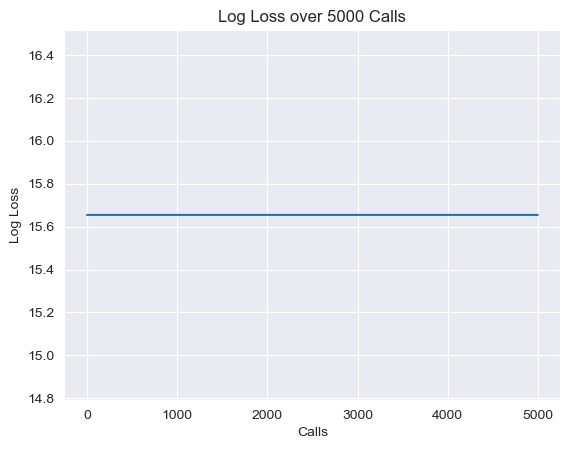

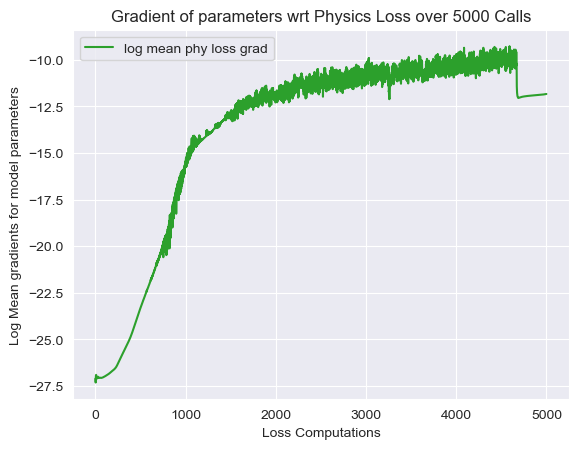

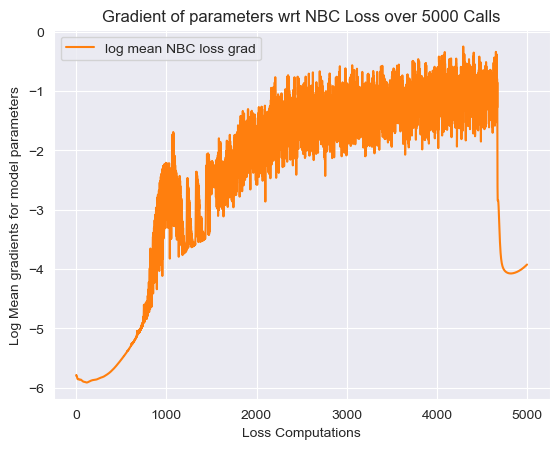

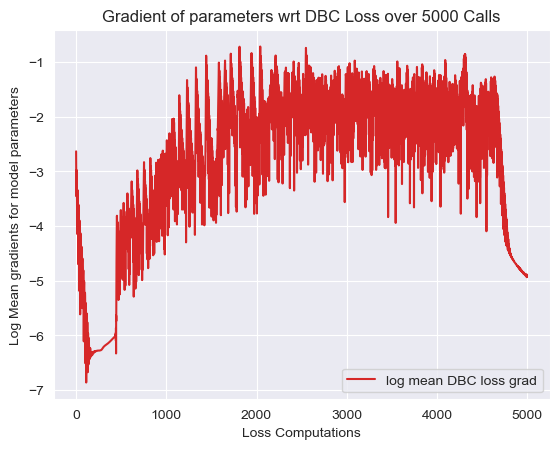

<Figure size 640x480 with 0 Axes>

In [48]:
# train
n_epochs = (5000,500)
w_update = 1
# start with Adam optimizer
optim = Adam(model.parameters())
prev_loss = list()

for epoch in range(n_epochs[0]):
    
    optim.step(closure)
    best_model_adam = checkpoint(best_model_adam)
    best_model = checkpoint(best_model)

    #if not (epoch%w_update): NBC_weight , DBC_weight = weight_update_norm(w_update)
    if not (epoch%500): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')

# plot for Adam optimization stage
plot_train()

Training with L-BGFS

Finished epoch 5000, latest loss 4.51E+15
Finished epoch 5010, latest loss 4.51E+15
Finished epoch 5020, latest loss 4.51E+15
Finished epoch 5030, latest loss 4.51E+15
Finished epoch 5040, latest loss 4.51E+15
Finished epoch 5050, latest loss 4.51E+15
Finished epoch 5060, latest loss 4.51E+15
Finished epoch 5070, latest loss 4.51E+15
Finished epoch 5080, latest loss 4.51E+15
Finished epoch 5090, latest loss 4.51E+15
Finished epoch 5100, latest loss 4.51E+15
Finished epoch 5110, latest loss 4.51E+15
Finished epoch 5120, latest loss 4.51E+15
Finished epoch 5130, latest loss 4.51E+15
Finished epoch 5140, latest loss 4.51E+15
Finished epoch 5150, latest loss 4.51E+15
Finished epoch 5160, latest loss 4.51E+15
Finished epoch 5170, latest loss 4.51E+15
Finished epoch 5180, latest loss 4.51E+15
Finished epoch 5190, latest loss 4.51E+15
Finished epoch 5200, latest loss 4.51E+15
Finished epoch 5210, latest loss 4.51E+15
Finished epoch 5220, latest loss 4.51E+15
Finished epoch 5230, latest loss 4

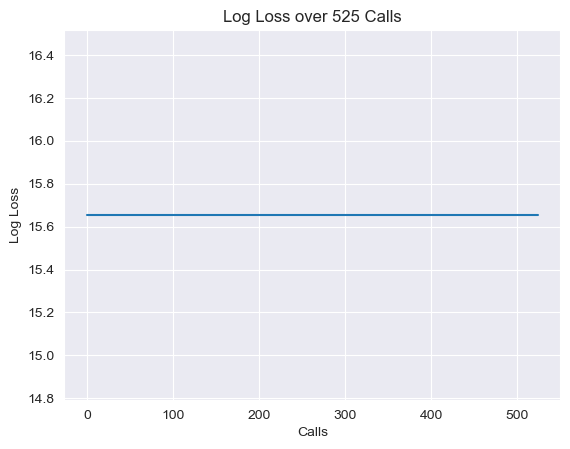

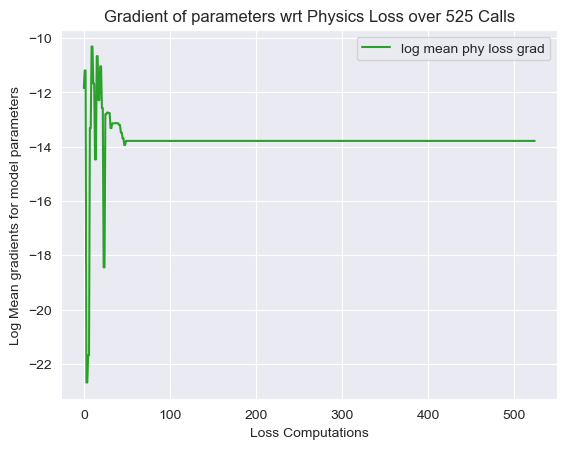

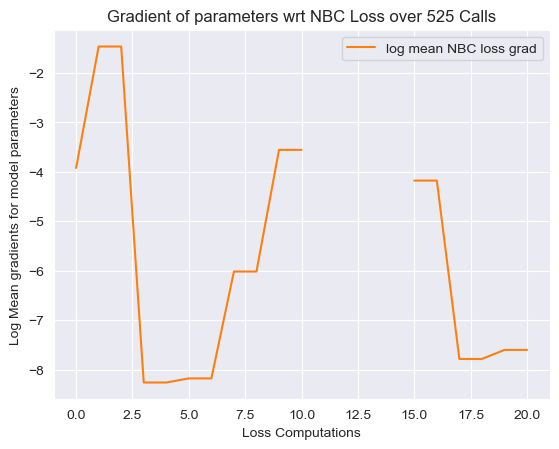

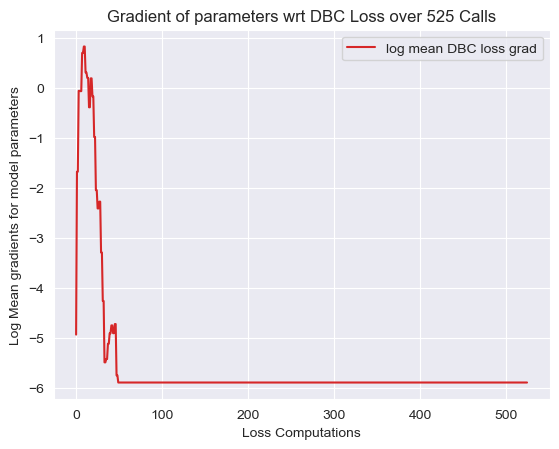

<Figure size 640x480 with 0 Axes>

In [49]:
# Change optim to L-BFGS
optim = LBFGS(model.parameters())

for epoch in range(n_epochs[0],sum(n_epochs)):
    
    optim.step(closure)
    best_model_LBFGS = checkpoint(best_model_LBFGS)
    best_model = checkpoint(best_model)

    #if not (epoch%w_update): ic_weight = weight_update_norm(w_update)
    if not (epoch%10): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')

plot_train(n_epochs[0])

Plotting best models

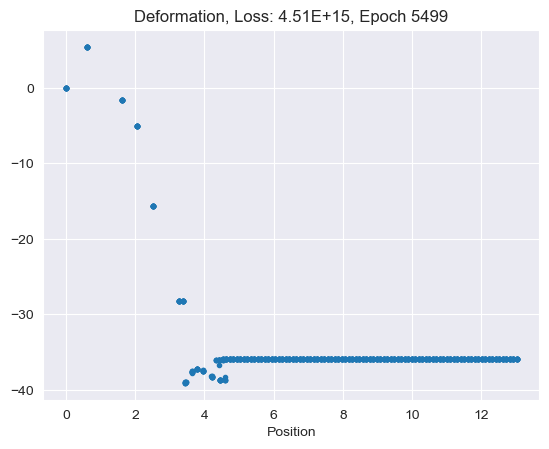

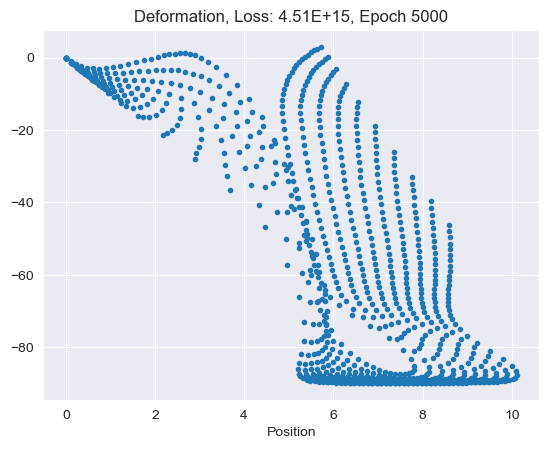

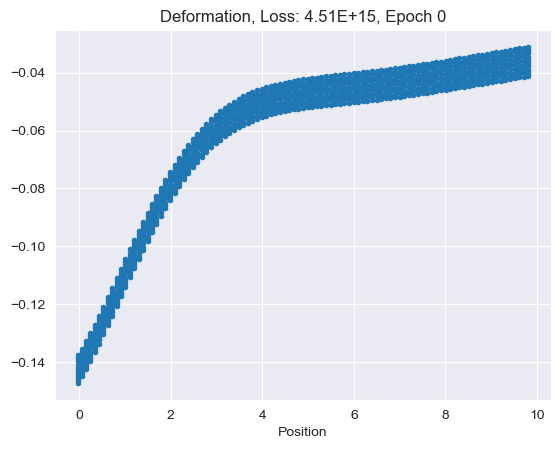

<Figure size 640x480 with 0 Axes>

In [50]:
plot_comp()

model.load_state_dict(best_model_LBFGS['model_state_dict'])
optim.load_state_dict(best_model_LBFGS['optimizer_state_dict'])
epoch = best_model_LBFGS['epoch']
loss = best_model_LBFGS['loss']
model.eval()
plot_comp()

model.load_state_dict(best_model['model_state_dict'])
optim.load_state_dict(best_model['optimizer_state_dict'])
epoch = best_model['epoch']
loss = best_model['loss']
model.eval()
plot_comp()

Saving Best Model

In [51]:
#PATH = f"Blender\\Models\\2D_Isotropic_Beam_{loss:.2E}_{epoch}.tar"
#torch.save(best_model, PATH)

Load Model

In [52]:
#PATH = "Blender\\Models\\2D_Isotropic_Beam_5.08E-04_5048.tar"

#checkpoint = torch.load(PATH, map_location=device)
#model.load_state_dict(checkpoint['model_state_dict'])
#optim.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

#model = model.to(device)
#model.eval()
#model.train()

Plotting Range

In [53]:
x_plot_range, x_plot_int = 10, 100
y_plot_range, y_plot_int = 10e-3, 5

Matplotlib Animation

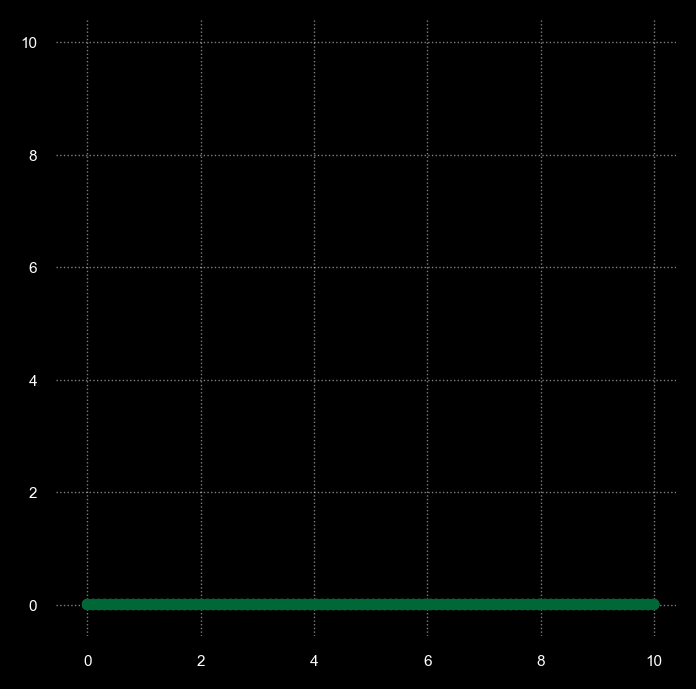

In [54]:
# obtaining plot range
plotting = grid(x_plot_range,y_plot_range,x_plot_int,y_plot_int).requires_grad_(True).to(device)
max_disp = 0

# obtaining plot data
model_pred = list()
for i in range(len(plotting)):
    #x,y,dx,dy
    pred = model(plotting[i])
    model_pred.append([plotting[i][0].item(), plotting[i][1].item(), pred[:,0].item(), pred[:,1].item()])
    if (np.sqrt(pred[:,0].item()**2 + pred[:,1].item()**2) > max_disp): max_disp = np.sqrt(pred[:,0].item()**2 + pred[:,1].item()**2)
model_pred = np.array(model_pred)

#setting up figure
fig, ax = plt.subplots(1,1,figsize=(4,4),dpi=200)
[ax.spines[side].set_visible(False) for side in ax.spines]
fig.set_facecolor("black")
ax.set_facecolor("black")
ax.tick_params(axis='both', colors='white', labelsize=5.5, grid_color='white', grid_alpha=0.5, grid_linewidth=0.5, grid_linestyle=':')
cmap = plt.get_cmap('RdYlGn_r')

#setting limits
init = model_pred[:,0:2]
disp = model_pred[:,0:2] + model_pred[:,2:]
buffer = 0.4

def anim_update(a):
    ax.clear()
    norm_disp = np.sqrt(model_pred[:,2]**2+model_pred[:,3]**2)*a/max_disp
    ax.scatter((model_pred[:,0] + a*model_pred[:,2]).T,(model_pred[:,1] + a*model_pred[:,3]).T,marker='.',c=cmap(norm_disp))
    ax.set_xlim([np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer])
    ax.set_ylim([np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer])
    return None    

anim = animation.FuncAnimation(fig, anim_update, frames=np.linspace(0,1,100), interval=25)
HTML(anim.to_html5_video())

Ploty and Dash Animaton

In [55]:
# obtaining plot range
plotting = plotting = grid(x_plot_range,y_plot_range,x_plot_int,y_plot_int).requires_grad_(True).to(device)
max_disp = 0

# obtaining plot data
model_pred = list()
for i in range(len(plotting)):
    #x,y,dx,dy
    pred = model(plotting[i])
    model_pred.append([plotting[i][0].item(), plotting[i][1].item(), pred[:,0].item(), pred[:,1].item()])
    if (np.sqrt(pred[:,0].item()**2 + pred[:,1].item()**2) > max_disp): max_disp = np.sqrt(pred[:,0].item()**2 + pred[:,1].item()**2)
model_pred = np.array(model_pred)

#setting limits
init = model_pred[:,0:2]
disp = model_pred[:,0:2] + model_pred[:,2:]
buffer = 0.4

init_scatter = go.Scatter3d(
    x=model_pred[:, 0],
    y=model_pred[:, 1],
    z=np.zeros(len(model_pred[:, 0])),
    mode='markers',
    marker=dict(
        size=3,
        colorscale='RdYlGn_r',
        color=np.zeros(len(model_pred[:, 0])),
        cmin=0,
        cmax=1,
        colorbar=dict(title='Normalized Displacement'),
    )
)

# Create init scatter
fig = go.Figure(data=[init_scatter])

# Create a Dash app
app = dash.Dash(__name__)

# Define the app layout
app.layout = html.Div([
    html.H1('Displacement Animation', style={'color': 'white'}),
    
    dcc.Graph(id='scatter-plot', figure=fig),
    
    dcc.Slider(
        id="frame-slider",
        min=0,
        max=100,
        step=0.1,
        value=0,
        marks={i: str(i) for i in range(0, 101, 10)},
        tooltip={"placement": "bottom"},
        updatemode='drag'
    )
])

# Callback to update the scatter plot
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('frame-slider', 'value')]
)

def update_scatter_plot(frame):
    # Update only the color data of the scatter plot
    fig.data[0].x = model_pred[:, 0] + frame * model_pred[:, 2] / 100
    fig.data[0].y =model_pred[:, 1] + frame * model_pred[:, 3] / 100
    fig.data[0].z =np.zeros(len(model_pred[:, 0]))
    fig.data[0].marker.color = np.sqrt(model_pred[:, 2]**2 + model_pred[:, 3]**2) * frame / max_disp / 100
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer]),
            yaxis=dict(range=[np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer]),
            zaxis=dict(range=[np.min(np.vstack([init, disp])) - buffer, np.max(np.vstack([init, disp])) + buffer]),
        ),
        autosize=False,
        width=800,
        height=600,
        uirevision='locked',
    )
    
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)